# Recursive QAOA

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params, Hamiltonian
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA, RQAOA
from openqaoa.problems.problem import QUBO, MaximumCut, MinimumVertexCover

In [2]:
# Set plotting style
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['font.size'] = '12'
#plt.rc('font', family='serif', size=600)

sns.axes_style("whitegrid")
sns.set_context("paper", font_scale=2.5)

In [3]:
def random_k_regular_graph_normal_distribution(degree: int,
                           nodes: List[int],
                           seed: int = None,
                           weighted: bool = False,
                           sigma: float = 1.0,
                           mu: float = 0.0,
                           biases: bool = False) -> nx.Graph:
    """
    Produces a random graph with specified number of nodes, each having degree k.

    Parameters
    ----------
    degree: `int`
        Desired degree for the nodes.
    nodes: `list`
        The node set of the graph.
    seed: `int`, optional
        A seed for the random number generator.
    weighted: `bool`, optional
        Whether the edge weights should be uniform or different. If false, all weights are set to 1.
        If true, the weight is set to a random number drawn from the uniform distribution in the
        interval 0 to 1.
    biases: `bool`, optional
        Whether or not the graph nodes should be assigned a weight.
        If true, the weight is set to a random number drawn from the uniform
        distribution in the interval 0 to 1.

    Returns
    -------
    nx.Graph: `Networkx Graph`
        A graph with the properties as specified.
    """
    # Set numpy seed
    np.random.seed(seed=seed)

    # Create a random regular graph on the nodes
    G = nx.random_regular_graph(degree, len(nodes), seed)

    # Relabel nodes
    nx.relabel_nodes(G, {i: n for i, n in enumerate(nodes)})

    # Add edges between nodes
    for edge in G.edges():

        # If weighted attribute is False, all weights are set to 1
        if not weighted:
            G[edge[0]][edge[1]]['weight'] = 1

        # If weighted attribute is True, weights are assigned as random integers
        else:
            G[edge[0]][edge[1]]['weight'] = np.random.normal(mu, sigma)

    # If biases attribute is True, add node weights as random integers
    if biases:
        for node in G.nodes():
            G.nodes[node]['weight'] = np.random.rand()

    return G

In [4]:
def run_Rqaoa_experiment(qubo, optimizer, init_beta, init_gamma):  
    
    # Define the RQAOA object (default rqaoa_type = 'adaptive')
    R = RQAOA()

    # Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3
    R.set_rqaoa_parameters(steps = 1, n_cutoff=3)

    ## Setting up the QAOA properties

    # Set the properties you want - These values are actually the default ones!
    #R.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
    R.set_circuit_properties(p=1, init_type='custom', variational_params_dict={"betas":[0.01], "gammas":[0.01]}, mixer_hamiltonian='x')

    # Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
    device = create_device(location='local', name='vectorized')
    R.set_device(device)

    # Set the classical method used to optimiza over QAOA angles and its properties
    R.set_classical_optimizer(method=optimizer, 
                              optimizer_options = {"stepsize" : 0.01},
                              tol=10**(-6), maxfev=6000, maxiter=2000, 
                              jac='finite_difference',
                              #parameter shift
                              hess='finite_difference',
                              optimization_progress=True, 
                              cost_progress=True, parameter_log=True)

    # Here are other ways in which the above selection can be generalized!

    # device = create_device(location = 'qcs',name = 'Aspen-11', as_qvm = True, client_configuraton = qcs_credentials)
    # r.set_device(device)
    # r.set_backend_properties(n_shots=100, cvar_alpha=1)
    # r.set_circuit_properties(param_type = 'extended', init_type = 'fourier_extended')
    # r.set_classical_optimizer(method='Nelder-Mead', maxiter=1000)
    

    # Compile problem instance on RQAOA, just like with QAOA
    R.compile(maxcut_qubo)
    
    R.optimize()
    
    return R.results


In [5]:
# helper function to produce the cost landscape
def create_cost_landscape_std(hamiltonian, betas, gammas):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.
    
    """
    
    cost_landscape = np.zeros((betas.size, gammas.size), dtype=float)
    
    for i, beta in enumerate(betas):
        for j, gamma in enumerate(gammas):
            variational_params = [beta, gamma]
            cost_landscape[i,j] = energy_expectation_analytical(variational_params, hamiltonian)
            
           
    return cost_landscape

In [6]:
def plot_landscape(cost_landscape, betas, gammas, sigma, mu):

    plt.contourf(cost_landscape, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

    #plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
    plt.xlabel(r'$\gamma$')
    plt.ylabel(r'$\beta$')
    plt.colorbar()
    #plt.savefig("cost_landscape_sigma={}_mu={}.png".format(sigma, mu))
    plt.show()
    

Sigma = 10
Seed = 1
Optimizer = rmsprop


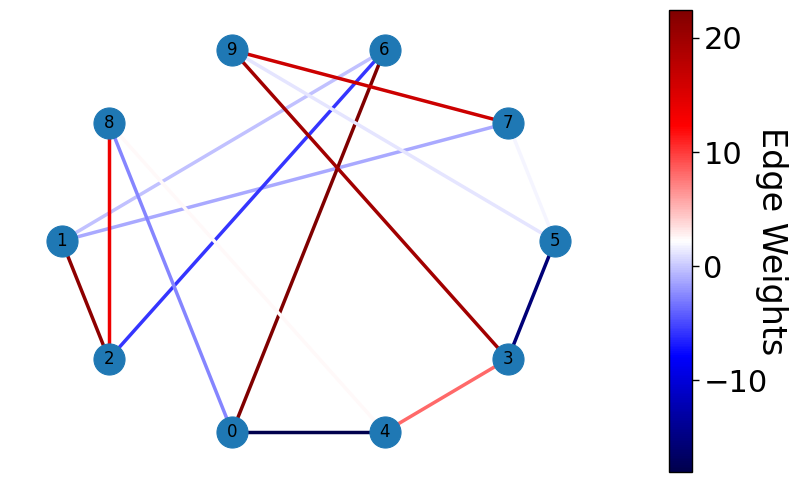

In [7]:
# Define problem

n = 10
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 5.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


optimizer_list = ["rmsprop"]
sigma_list = [10]

#seed_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

seed_list = [1]

data = []  # list to contain optimization results to be converted into a data frame

for sigma in sigma_list:
    print("Sigma =", sigma)
    
    for seed in seed_list:
        print("Seed =", seed)

        # Define 3wR graph and plot it
        g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
        plot_graph(g)
        #plt.savefig("graph_sigma={}.png".format(sigma))
        #plt.clf()

        # Define te problem and translate it into a binary Qubo.
        maxcut_prob = MaximumCut(g)
        maxcut_qubo = maxcut_prob.get_qubo_problem()

        # Define Hamiltonian
        cost_hamiltonian = hamiltonian_from_graph(g)

        #cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
        #plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


        for optimizer in optimizer_list:
            print("Optimizer =", optimizer)

            # initialize away from the minimum
            init_beta = 0.5
            init_gamma = -0.2

            opt_results = run_Rqaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

            optimization_energy = list(opt_results['solution'].values())[0]
            
            # Solve the problem analytically
            energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

            # Obtain approximation ratio
            r = np.abs(optimization_energy) / np.abs(energy)
            
            data.append([sigma, optimizer, seed, r])

df = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'seed', 'r'])

df['sigma'] = df['sigma'].astype(float)
df['optimizer'] = df['optimizer'].astype(str)
df['seed'] = df['seed'].astype(int)
df['r'] = df['r'].astype(float)

In [8]:
df

,sigma,optimizer,seed,r
0,10.0,rmsprop,1,1.0


In [9]:
opt_results

{'solution': {'1011000011': -138.9314122098009,
  '0100111100': -138.9314122098009},
 'classical_output': {'minimum_energy': -12.62656828672251,
  'optimal_states': ['110', '001']},
 'elimination_rules': [{(0, 1): -1.0},
  {(1, 6): -1.0},
  {(1, 2): 1.0},
  {(0, 6): 1.0},
  {(2, 5): -1.0},
  {(2, 3): 1.0},
  {(2, 3): 1.0}],
 'schedule': [1, 1, 1, 1, 1, 1, 1],
 'intermediate_steps': [{'QUBO': <openqaoa.problems.problem.QUBO at 0x7f164845ae30>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7f1648459f60>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7f1648458c70>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7f1648458bb0>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7f16483225c0>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7f1648322530>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7f16480663b0>,
   'QAOA': <openqaoa.workflows.optimizer.QAOA at 0x7f1648065630>},
  {'QUBO': <openqaoa.problems.problem.QUBO at 0x7f1647f95540>,
   'QAOA': <openqaoa.workflows.op

In [10]:
intermediate_steps = len(opt_results['intermediate_steps'])
intermediate_steps

7

Graph with 9 nodes and 13 edges
Graph with 8 nodes and 12 edges
Graph with 7 nodes and 10 edges
Graph with 6 nodes and 8 edges
Graph with 5 nodes and 6 edges
Graph with 4 nodes and 4 edges
Graph with 3 nodes and 3 edges


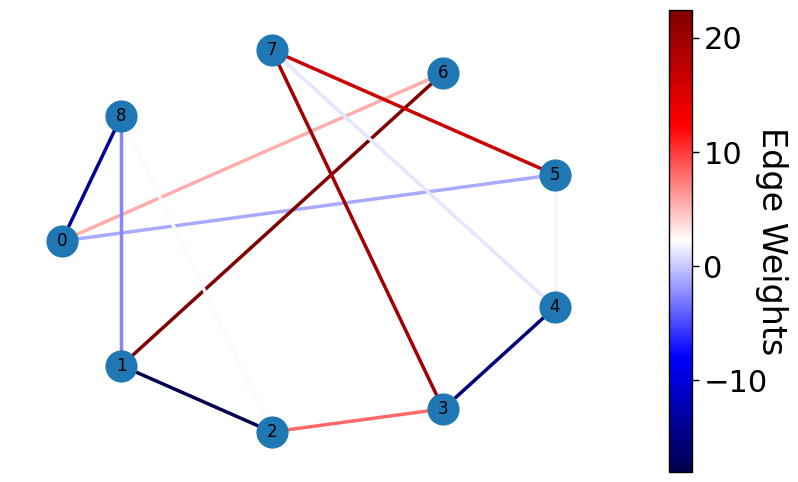

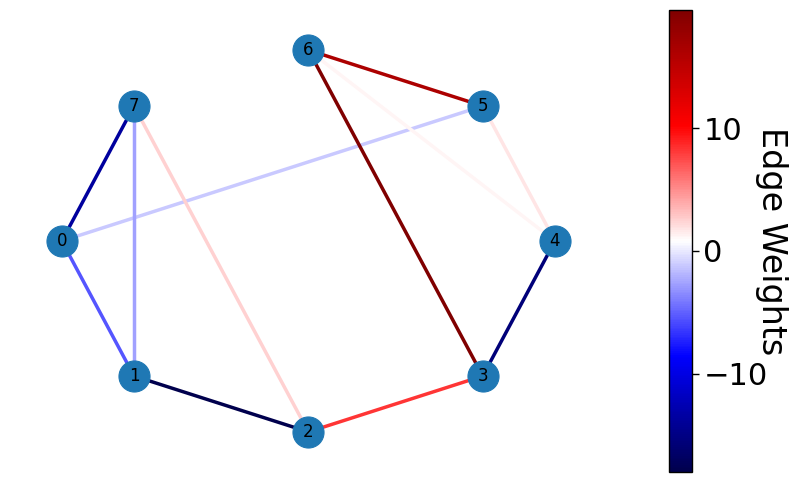

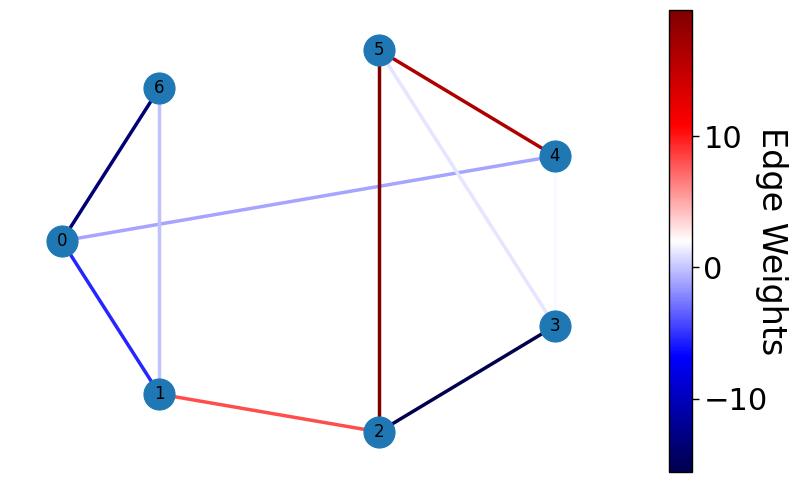

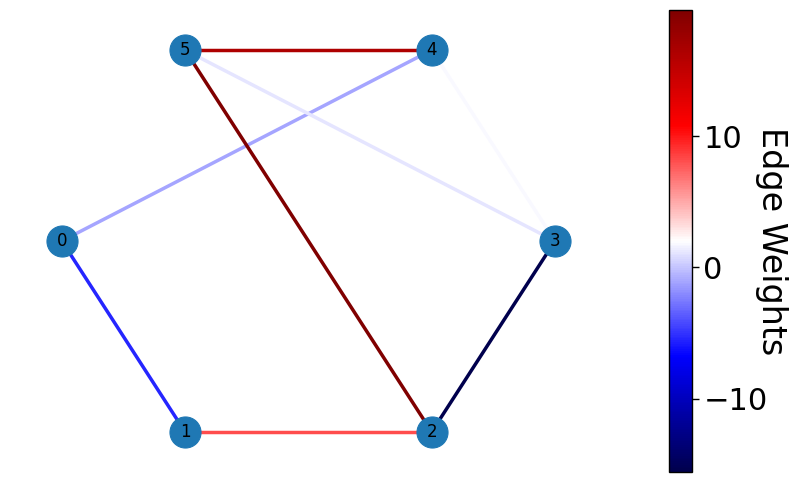

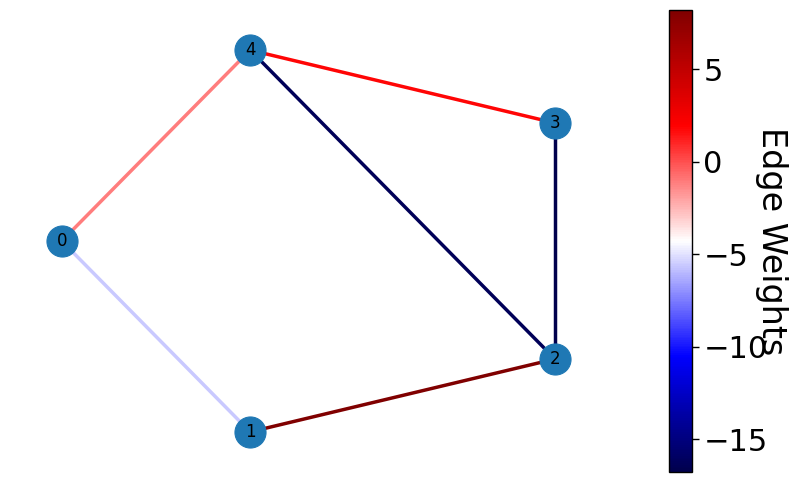

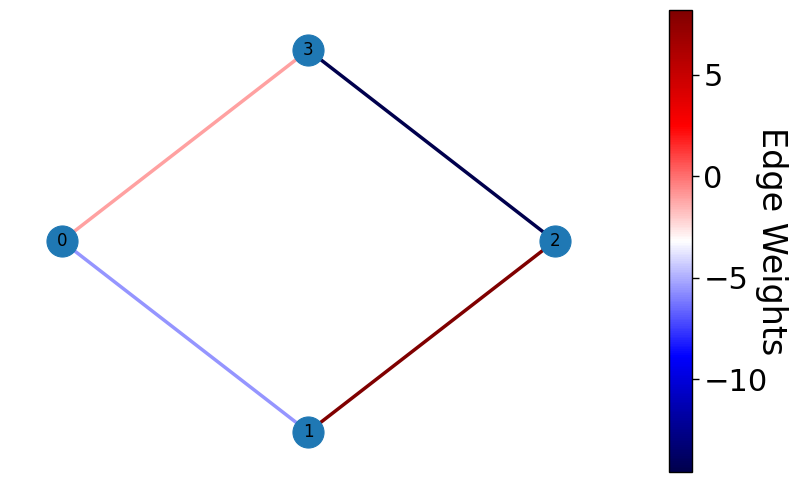

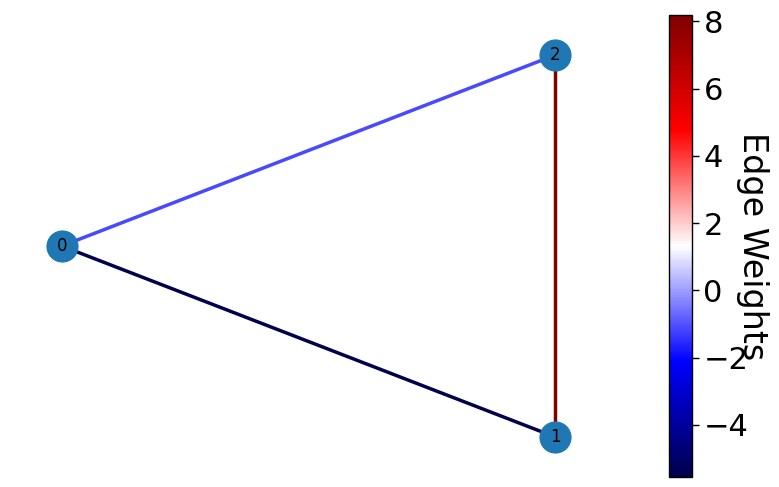

In [11]:
for i in range(0, intermediate_steps):
    intermediate_qubo = opt_results['intermediate_steps'][i]['QUBO']
    intermediate_hamiltonian = intermediate_qubo.hamiltonian
    intermediate_g = graph_from_hamiltonian(intermediate_hamiltonian)
    print(intermediate_g)
    plot_graph(intermediate_g)

In [12]:
opt_results['intermediate_exp_vals_z']

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0.])]

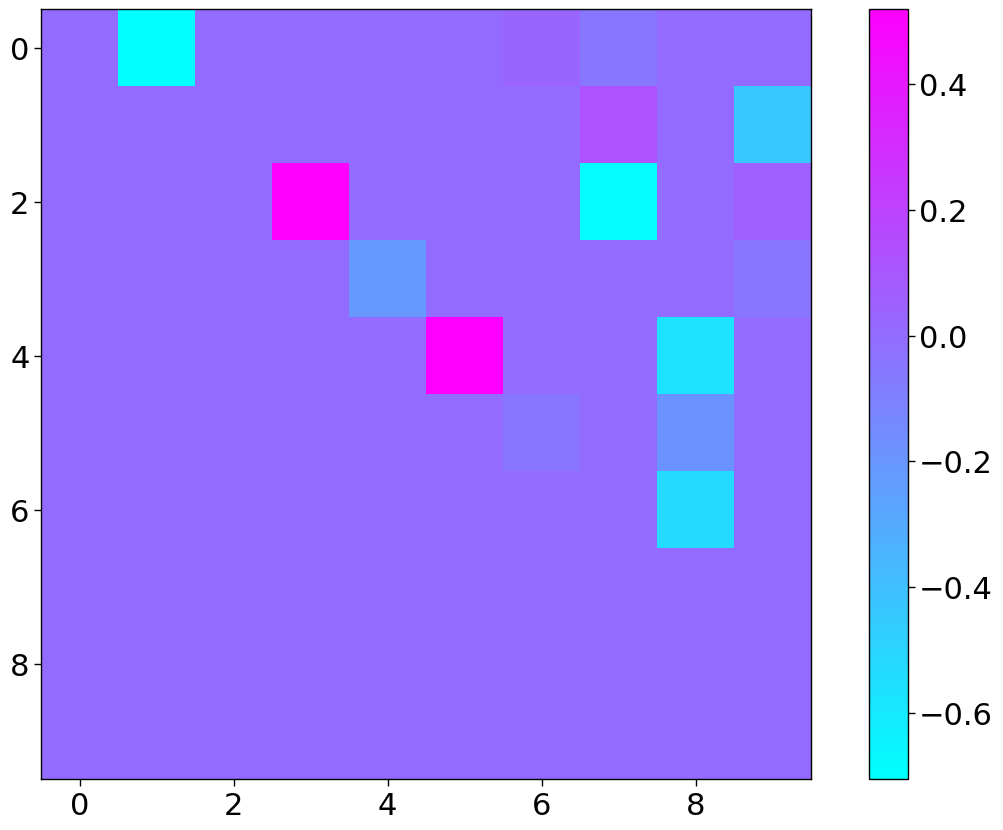

In [13]:
plt.imshow(opt_results['intermediate_corr_matrix'][0], cmap="cool")
plt.colorbar()

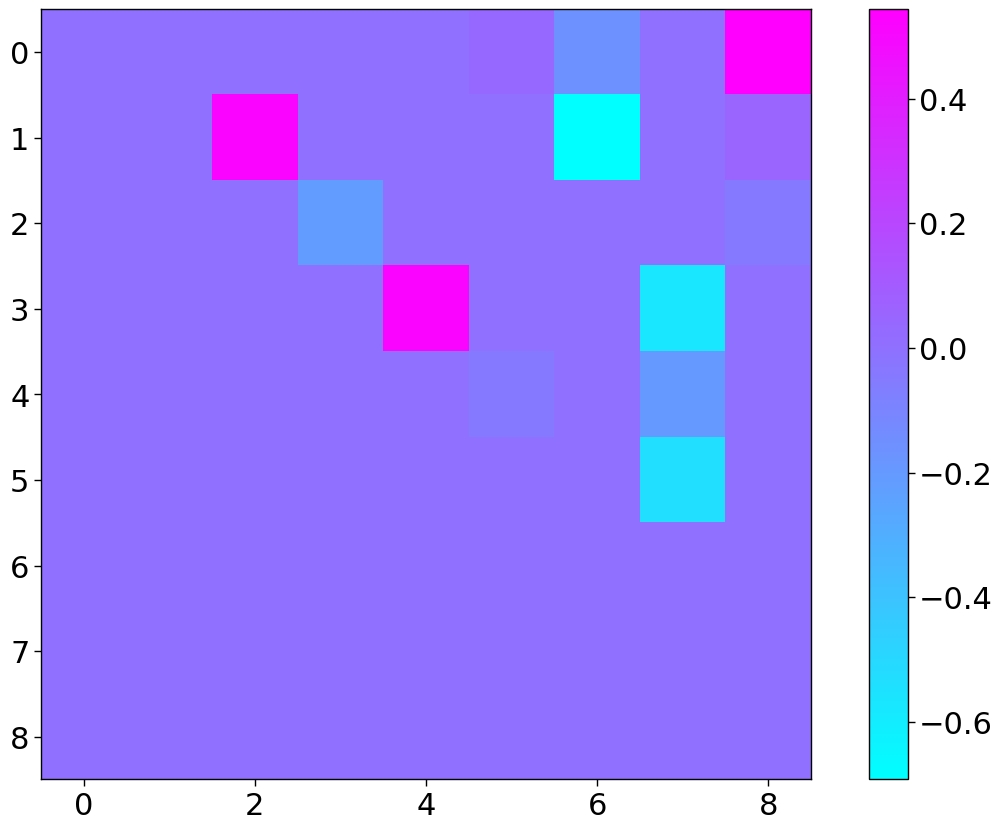

In [14]:
plt.imshow(opt_results['intermediate_corr_matrix'][1], cmap="cool")
plt.colorbar()

Graph with 9 nodes and 13 edges


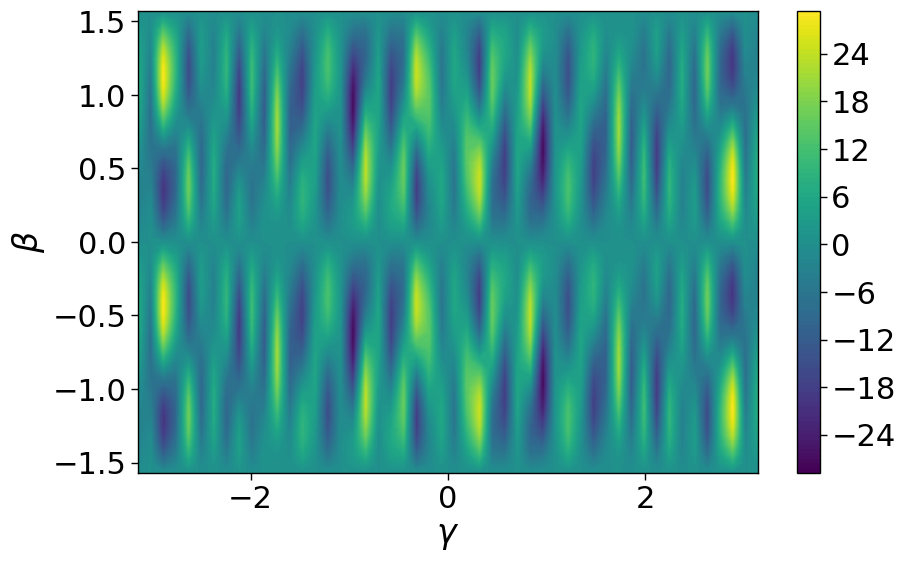

Graph with 8 nodes and 12 edges


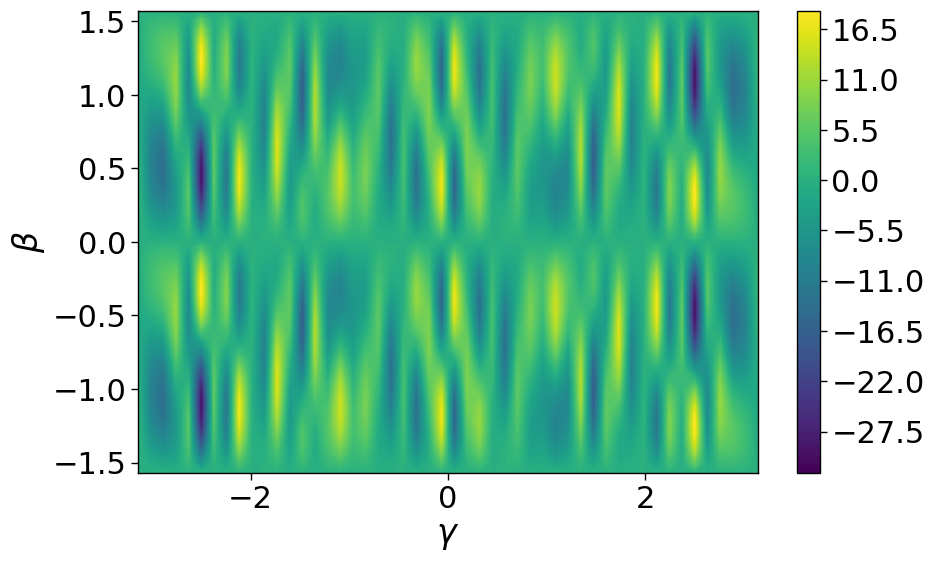

Graph with 7 nodes and 10 edges


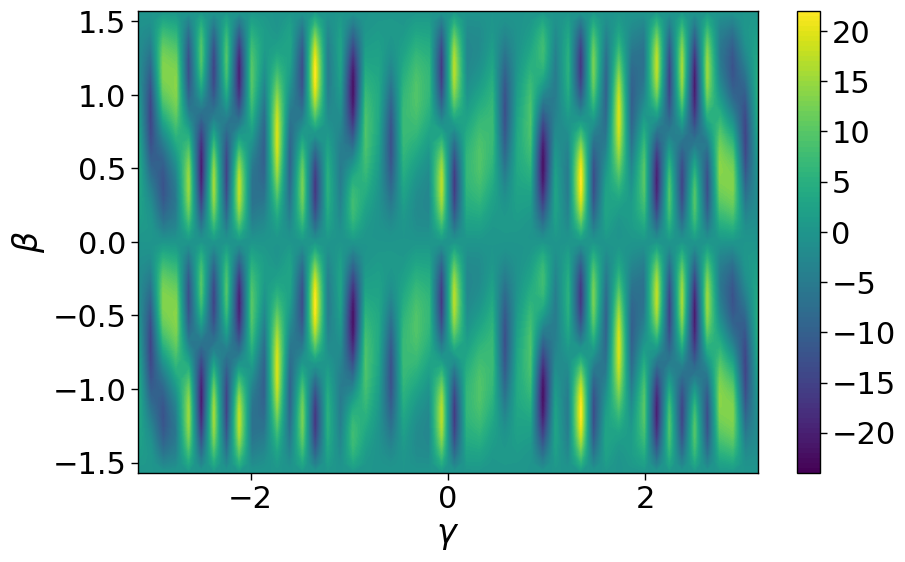

Graph with 6 nodes and 8 edges


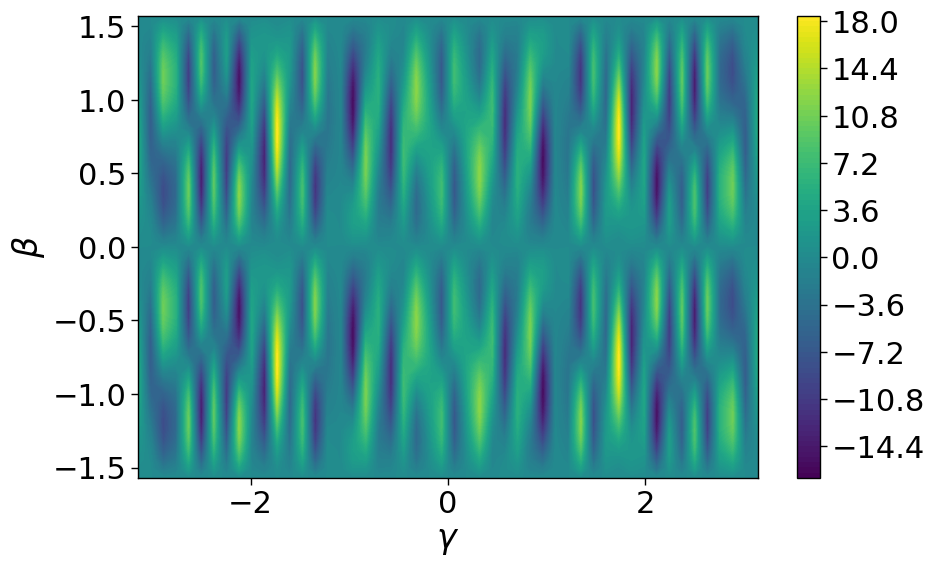

Graph with 5 nodes and 6 edges


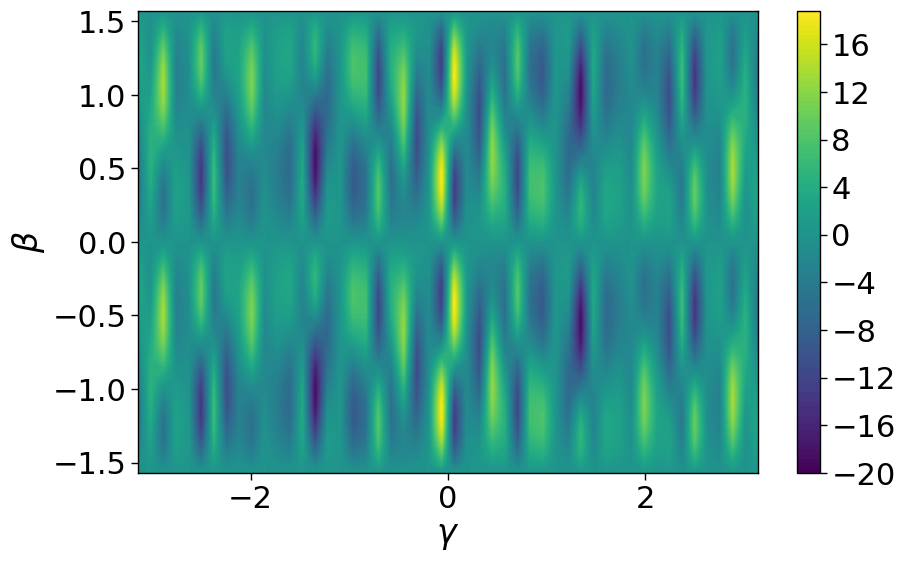

Graph with 4 nodes and 4 edges


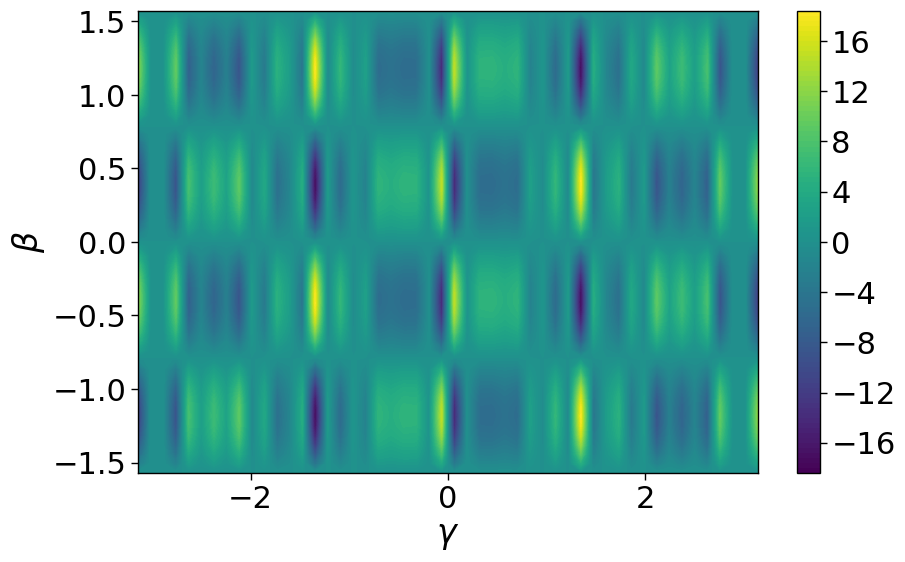

Graph with 3 nodes and 3 edges


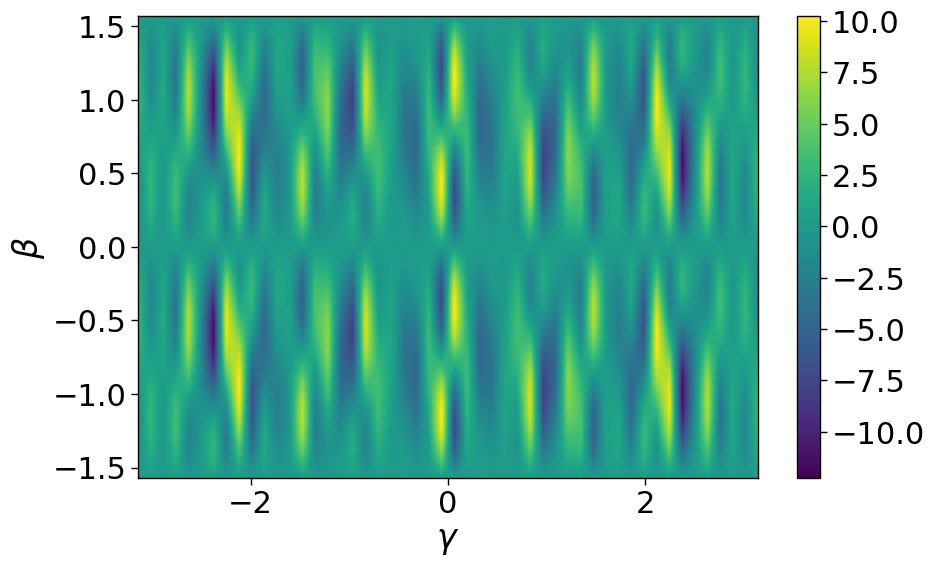

In [15]:
for i in range(0, intermediate_steps):
    intermediate_qubo = opt_results['intermediate_steps'][i]['QUBO']
    intermediate_hamiltonian = intermediate_qubo.hamiltonian
    intermediate_g = graph_from_hamiltonian(intermediate_hamiltonian)
    print(intermediate_g)
    plot_graph(intermediate_g)
    plt.clf()
    cost_landscape = create_cost_landscape_std(intermediate_hamiltonian, betas, gammas)
    plot_landscape(cost_landscape, betas, gammas, sigma, mu)


In [22]:
data

[[0.1, 'rmsprop', 1, 1.0],
 [0.1, 'cobyla', 1, 1.0],
 [0.1, 'rmsprop', 2, 1.0],
 [0.1, 'cobyla', 2, 1.0],
 [0.1, 'rmsprop', 3, 1.0],
 [0.1, 'cobyla', 3, 1.0],
 [0.1, 'rmsprop', 4, 1.0],
 [0.1, 'cobyla', 4, 1.0],
 [0.1, 'rmsprop', 5, 1.0],
 [0.1, 'cobyla', 5, 1.0],
 [0.1, 'rmsprop', 6, 1.0],
 [0.1, 'cobyla', 6, 1.0],
 [0.1, 'rmsprop', 7, 0.8593490810223763],
 [0.1, 'cobyla', 7, 1.0],
 [0.1, 'rmsprop', 8, 1.0],
 [0.1, 'cobyla', 8, 1.0],
 [0.1, 'rmsprop', 9, 1.0],
 [0.1, 'cobyla', 9, 1.0],
 [0.1, 'rmsprop', 10, 1.0],
 [0.1, 'cobyla', 10, 1.0],
 [0.1, 'rmsprop', 11, 1.0],
 [0.1, 'cobyla', 11, 1.0],
 [0.1, 'rmsprop', 12, 0.9912378368988646],
 [0.1, 'cobyla', 12, 0.9912378368988646],
 [0.1, 'rmsprop', 13, 1.0],
 [0.1, 'cobyla', 13, 1.0],
 [0.1, 'rmsprop', 14, 1.0],
 [0.1, 'cobyla', 14, 1.0],
 [0.1, 'rmsprop', 15, 1.0],
 [0.1, 'cobyla', 15, 1.0],
 [0.1, 'rmsprop', 16, 1.0],
 [0.1, 'cobyla', 16, 1.0],
 [0.1, 'rmsprop', 17, 1.0],
 [0.1, 'cobyla', 17, 1.0],
 [0.1, 'rmsprop', 18, 1.0],
 [0.1, 'co

### Averaging over Optimizers

In [27]:
# Define problem

n = 12
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 5.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

optimizer_list = ["rmsprop", 'cobyla']

optimizer_list = ['powell']

seed_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

#seed_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#data = []  # list to contain optimization results to be converted into a data frame

for sigma in sigma_list:
    print("Sigma =", sigma)
    
    for seed in seed_list:
        print("Seed =", seed)

        # Define 3wR graph and plot it
        g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
        #plot_graph(g)
        #plt.savefig("graph_sigma={}.png".format(sigma))
        #plt.clf()

        # Define te problem and translate it into a binary Qubo.
        maxcut_prob = MaximumCut(g)
        maxcut_qubo = maxcut_prob.get_qubo_problem()

        # Define Hamiltonian
        cost_hamiltonian = hamiltonian_from_graph(g)

        #cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
        #plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


        for optimizer in optimizer_list:
            print("Optimizer =", optimizer)

            # initialize away from the minimum
            init_beta = 0.5
            init_gamma = -0.2

            opt_results = run_Rqaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

            optimization_energy = list(opt_results['solution'].values())[0]
            
            # Solve the problem analytically
            energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

            # Obtain approximation ratio
            r = np.abs(optimization_energy) / np.abs(energy)
            
            data.append([sigma, optimizer, seed, r])

df = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'seed', 'r'])

df['sigma'] = df['sigma'].astype(float)
df['optimizer'] = df['optimizer'].astype(str)
df['seed'] = df['seed'].astype(int)
df['r'] = df['r'].astype(float)

Sigma = 0.1
Seed = 1
Optimizer = powell


/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


Seed = 2
Optimizer = powell
Seed = 3
Optimizer = powell
Seed = 4
Optimizer = powell
Seed = 5
Optimizer = powell
Seed = 6
Optimizer = powell
Seed = 7
Optimizer = powell
Seed = 8
Optimizer = powell
Seed = 9
Optimizer = powell
Seed = 10
Optimizer = powell
Seed = 11
Optimizer = powell
Seed = 12
Optimizer = powell
Seed = 13
Optimizer = powell
Seed = 14
Optimizer = powell
Seed = 15
Optimizer = powell
Seed = 16
Optimizer = powell
Seed = 17
Optimizer = powell
Seed = 18
Optimizer = powell
Seed = 19
Optimizer = powell
Seed = 20
Optimizer = powell
Seed = 21
Optimizer = powell
Seed = 22
Optimizer = powell
Seed = 23
Optimizer = powell
Seed = 24
Optimizer = powell
Seed = 25
Optimizer = powell
Seed = 26
Optimizer = powell
Seed = 27
Optimizer = powell
Seed = 28
Optimizer = powell
Seed = 29
Optimizer = powell
Seed = 30
Optimizer = powell
Seed = 31
Optimizer = powell
Seed = 32
Optimizer = powell
Seed = 33
Optimizer = powell
Seed = 34
Optimizer = powell
Seed = 35
Optimizer = powell
Seed = 36
Optimizer = 

In [28]:
df

,sigma,optimizer,seed,r
0,0.1,rmsprop,1,1.000000
1,0.1,cobyla,1,1.000000
2,0.1,rmsprop,2,1.000000
3,0.1,cobyla,2,1.000000
4,0.1,rmsprop,3,1.000000
...,...,...,...,...
1595,100.0,powell,96,1.000000
1596,100.0,powell,97,0.914934
1597,100.0,powell,98,0.875538
1598,100.0,powell,99,0.794516


In [29]:
#df.to_csv("data_22.11_RQAOA_seeds_100_optimizers.csv")

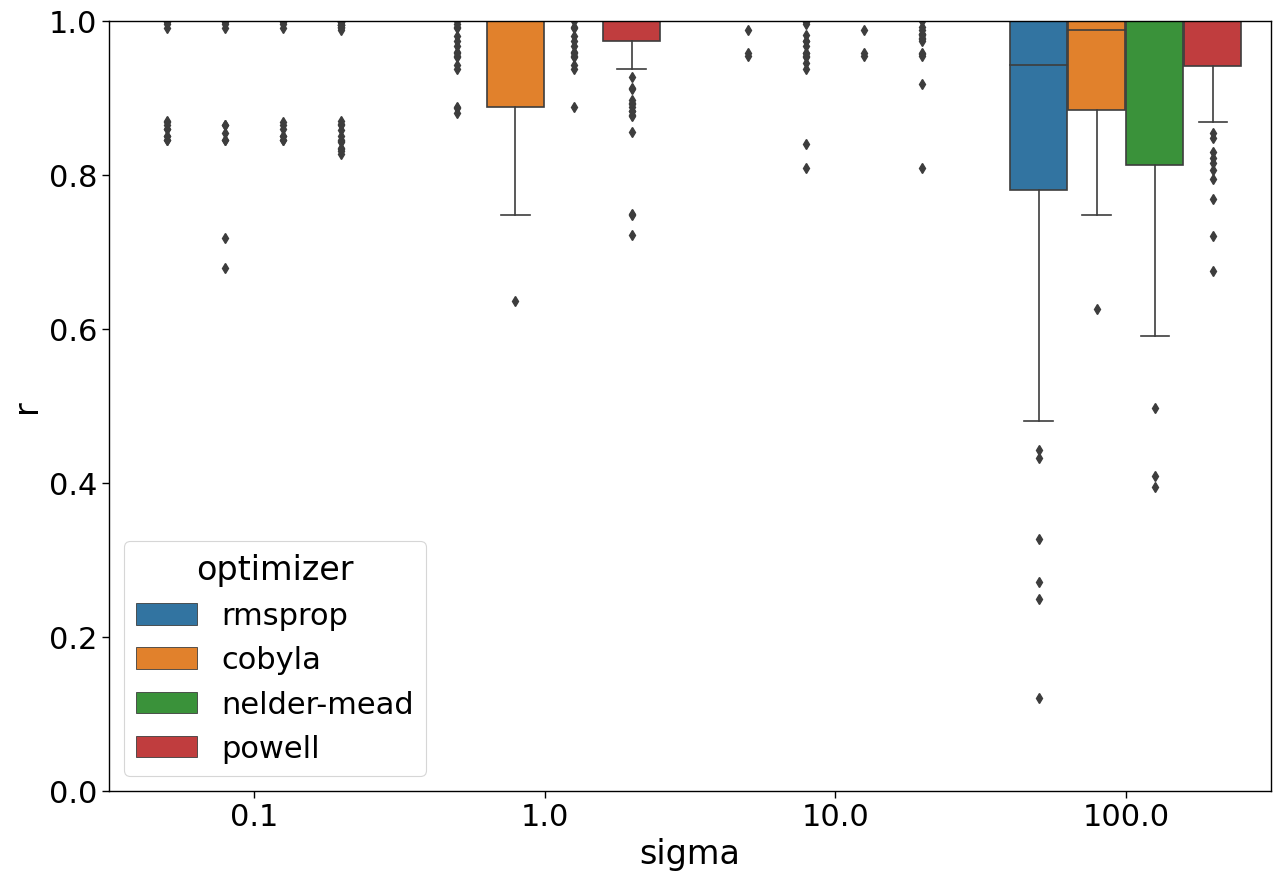

In [39]:
#plt.xscale('log')
plt.ylim(0, 1)
box_plot = sns.boxplot(data = df, x = 'sigma', y ='r', hue="optimizer")

plt.savefig("Approximation_ratio_mu=5.0_RQAOA_ramp_optimizers.png")


In [36]:
%%time

# Define problem

n = 12
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 5.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

optimizer_list = ["cobyla"]

#seed_list = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

seed_list = [1, 2]

#data = []  # list to contain optimization results to be converted into a data frame

for sigma in sigma_list:
    print("Sigma =", sigma)
    
    for seed in seed_list:
        print("Seed =", seed)

        # Define 3wR graph and plot it
        g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
        #plot_graph(g)
        #plt.savefig("graph_sigma={}.png".format(sigma))
        #plt.clf()

        # Define te problem and translate it into a binary Qubo.
        maxcut_prob = MaximumCut(g)
        maxcut_qubo = maxcut_prob.get_qubo_problem()

        # Define Hamiltonian
        cost_hamiltonian = hamiltonian_from_graph(g)

        #cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
        #plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


        for optimizer in optimizer_list:
            print("Optimizer =", optimizer)

            # initialize away from the minimum
            init_beta = 0.5
            init_gamma = -0.2

            opt_results = run_Rqaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

            optimization_energy = list(opt_results['solution'].values())[0]
            
            # Solve the problem analytically
            energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

            # Obtain approximation ratio
            r = np.abs(optimization_energy) / np.abs(energy)
            
            #data.append([sigma, optimizer, seed, r])

'''
df = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'seed', 'r'])

df['sigma'] = df['sigma'].astype(float)
df['optimizer'] = df['optimizer'].astype(str)
df['seed'] = df['seed'].astype(int)
df['r'] = df['r'].astype(float)
'''

Sigma = 0.1
Seed = 1
Optimizer = cobyla
Seed = 2
Optimizer = cobyla
Sigma = 1
Seed = 1
Optimizer = cobyla
Seed = 2
Optimizer = cobyla
Sigma = 10
Seed = 1
Optimizer = cobyla
Seed = 2
Optimizer = cobyla
Sigma = 100
Seed = 1
Optimizer = cobyla
Seed = 2
Optimizer = cobyla
CPU times: user 54.7 s, sys: 24 ms, total: 54.7 s
Wall time: 54.7 s


"\ndf = pd.DataFrame(np.array(data), columns=['sigma', 'optimizer', 'seed', 'r'])\n\ndf['sigma'] = df['sigma'].astype(float)\ndf['optimizer'] = df['optimizer'].astype(str)\ndf['seed'] = df['seed'].astype(int)\ndf['r'] = df['r'].astype(float)\n"

In [ ]:
%%timeit

n = 12
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 5.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

optimizer_list = ["rmsprop"]

seed_list = [1]

g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
#plot_graph(g)
#plt.savefig("graph_sigma={}.png".format(sigma))
#plt.clf()

# Define te problem and translate it into a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()

# Define Hamiltonian
cost_hamiltonian = hamiltonian_from_graph(g)

#cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
#plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


for optimizer in optimizer_list:
    #print("Optimizer =", optimizer)

    # initialize away from the minimum
    init_beta = 0.5
    init_gamma = -0.2

    opt_results = run_Rqaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

    optimization_energy = list(opt_results['solution'].values())[0]

    # Solve the problem analytically
    energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

    # Obtain approximation ratio
    r = np.abs(optimization_energy) / np.abs(energy)

In [41]:
%%timeit

n = 12
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 5.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

optimizer_list = ["cobyla"]

seed_list = [1]

g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
#plot_graph(g)
#plt.savefig("graph_sigma={}.png".format(sigma))
#plt.clf()

# Define te problem and translate it into a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()

# Define Hamiltonian
cost_hamiltonian = hamiltonian_from_graph(g)

#cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
#plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


for optimizer in optimizer_list:
    #print("Optimizer =", optimizer)

    # initialize away from the minimum
    init_beta = 0.5
    init_gamma = -0.2

    opt_results = run_Rqaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

    optimization_energy = list(opt_results['solution'].values())[0]

    # Solve the problem analytically
    energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

    # Obtain approximation ratio
    r = np.abs(optimization_energy) / np.abs(energy)

/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


15.3 s ± 83.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%%timeit

n = 12
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 5.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

optimizer_list = ["nelder-mead"]

seed_list = [1]

g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
#plot_graph(g)
#plt.savefig("graph_sigma={}.png".format(sigma))
#plt.clf()

# Define te problem and translate it into a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()

# Define Hamiltonian
cost_hamiltonian = hamiltonian_from_graph(g)

#cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
#plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


for optimizer in optimizer_list:
    #print("Optimizer =", optimizer)

    # initialize away from the minimum
    init_beta = 0.5
    init_gamma = -0.2

    opt_results = run_Rqaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

    optimization_energy = list(opt_results['solution'].values())[0]

    # Solve the problem analytically
    energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

    # Obtain approximation ratio
    r = np.abs(optimization_energy) / np.abs(energy)

/home/kristina/assignments/openqaoa/openqaoa/optimizers/training_vqa.py:466: OptimizeWarning: Unknown solver options: stepsize
  result = minimize(self.optimize_this, x0=self.initial_params, method=self.method,


1.02 s ± 5.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
%%timeit

n = 12
k = 3
sigma_list = [0.1, 1, 10, 100]
mu = 5.0 
betas = np.linspace(-np.pi/2, np.pi/2, 50)
gammas = np.linspace(-np.pi, np.pi, 50)


#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]

optimizer_list = ["powell"]

seed_list = [1]

g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=seed, weighted=True, mu=mu, sigma=sigma, biases=False)
#plot_graph(g)
#plt.savefig("graph_sigma={}.png".format(sigma))
#plt.clf()

# Define te problem and translate it into a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()

# Define Hamiltonian
cost_hamiltonian = hamiltonian_from_graph(g)

#cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, betas, gammas)
#plot_landscape(cost_landscape_std, betas, gammas, sigma, mu)


for optimizer in optimizer_list:
    #print("Optimizer =", optimizer)

    # initialize away from the minimum
    init_beta = 0.5
    init_gamma = -0.2

    opt_results = run_Rqaoa_experiment(maxcut_qubo, optimizer, init_beta, init_gamma)

    optimization_energy = list(opt_results['solution'].values())[0]

    # Solve the problem analytically
    energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

    # Obtain approximation ratio
    r = np.abs(optimization_energy) / np.abs(energy)

1.04 s ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
data_time=[]
data_time.append(['cobyla', '15.3'])
data_time.append(['powell', '1.04'])
data_time.append(['nelder-mead', '1.02'])


df_time = pd.DataFrame(np.array(data_time), columns=['optimizer', 'time'])


df_time['optimizer'] = df['optimizer'].astype(str)
df_time['time'] = df['time'].astype(float)  # in seconds